目标格式：  
. 工作路径
├── datasets  
│   └── custom_dataset  
│       ├── images  
│       │   ├── train  
│       │   │   └── demo_001.jpg  
│       │   └── val  
│       │       └── demo_002.jpg  
│       └── labels  
│           ├── train  
│           │   └── demo_001.txt  
│           └── val  
│               └── demo_002.txt  
└── 其他文件、文件夹  

In [16]:
import os
import sys
import glob
import cv2
import tqdm

root_dir = '/home/scc/Downloads/AIToy/P2_Yolov8CarCount/3.train_own_data/raws_dataset'

In [9]:
# 训练集目录
train_dir = os.path.join(root_dir, "VisDrone2019-DET-train")
# 测试集目录
val_dir = os.path.join(root_dir, "VisDrone2019-DET-val")

# 训练集图片目录、标注目录
train_img_dir = train_dir + "/images"
train_anno_dir = train_dir + "/annotations"
# 测试集图片目录、标注目录
test_img_dir = val_dir + "/images"
test_anno_dir = val_dir + "/annotations"

# 统计数量
print("训练集图片数量：", len(os.listdir(train_img_dir)))
print("训练集标注数量：", len(os.listdir(train_anno_dir)))
print("测试集图片数量：", len(os.listdir(test_img_dir)))
print("测试集标注数量：", len(os.listdir(test_anno_dir)))

训练集图片数量： 6471
训练集标注数量： 6471
测试集图片数量： 548
测试集标注数量： 548


In [12]:
# 查看一个标注sample
sample_label_file = glob.glob(train_anno_dir + '/*.txt')[0]

In [15]:
# 读取内容
with open(sample_label_file, "r", encoding="utf-8") as fd:
    lines = fd.readlines()


# visdrone data format
# <bbox_left>,<bbox_top>,<bbox_width>,<bbox_height>,<score>,<object_category>,<truncation>,<occlusion>
# 即：左上角坐标，宽，高，置信度，类别，截断，遮挡

lines

['435,742,45,45,1,4,1,0\n',
 '617,733,35,54,1,4,1,0\n',
 '445,571,36,59,1,4,0,0\n',
 '494,429,34,45,1,4,0,0\n',
 '473,361,28,37,1,4,0,0\n',
 '921,564,60,60,1,4,0,0\n',
 '489,77,19,23,1,4,0,0\n',
 '516,64,17,21,1,4,0,0\n',
 '618,64,15,27,1,4,0,0\n',
 '494,29,15,19,1,4,0,0\n',
 '518,16,13,18,1,4,0,0\n',
 '539,2,13,14,1,4,0,0\n',
 '414,41,17,23,1,4,0,0\n',
 '322,110,23,22,1,4,0,0\n',
 '216,219,10,22,1,1,0,0\n',
 '503,248,35,63,1,9,0,0\n',
 '533,112,24,44,1,6,0,0\n',
 '676,351,44,65,1,5,0,0\n',
 '0,66,28,25,1,4,1,0\n',
 '196,89,37,25,1,4,0,2\n',
 '181,156,34,23,1,4,0,0\n',
 '240,46,52,30,1,6,0,0\n',
 '293,37,34,23,1,4,0,0\n',
 '329,23,32,24,1,5,0,0\n',
 '189,60,24,17,1,4,0,0\n',
 '199,32,23,12,1,4,0,0\n',
 '241,25,24,13,1,4,0,0\n',
 '264,11,21,12,1,4,0,0\n',
 '267,18,23,14,1,4,0,0\n',
 '234,19,25,17,1,4,0,1\n',
 '163,42,26,18,1,4,0,0\n',
 '191,44,28,16,1,4,0,1\n',
 '270,32,24,13,1,4,0,1\n',
 '318,15,23,15,1,4,0,1\n',
 '327,11,29,17,1,4,0,1\n',
 '211,51,25,16,1,4,0,0\n',
 '226,43,23,16,1,4,

In [17]:
# 目标YOLO格式：类别id、x_center y_center width height

In [18]:
# 原数据集的类别标签
label_map = {
    0: "pedestrian",
    1: "people",
    2: "bicycle",
    3: "car",
    4: "van",
    5: "truck",
    6: "tricycle",
    7: "awning-tricycle",
    8: "bus",
    9: "motor",
}

In [19]:
"""
根据原始标注文件、图片文件，转换为yolo格式的标注文件
@data_file: 原始标注文件
@img_file: 图片文件

@results: yolo格式的标注文件
"""


def transform_data(data_file, img_file):
    with open(data_file, "r", encoding="utf-8") as fd:
        lines = fd.readlines()

    image = cv2.imread(img_file)
    height, width, _ = image.shape

    results = []
    for line in lines:
        element = line.strip().split(",")
        bbox_left = float(element[0])
        bbox_top = float(element[1])
        bbox_width = float(element[2])
        bbox_height = float(element[3])
        object_category = int(element[5]) - 1

        if object_category not in label_map.keys():
            continue

        center_x = (bbox_left + bbox_width / 2) / width
        center_y = (bbox_top + bbox_height / 2) / height
        b_width = bbox_width / width
        b_height = bbox_height / height
        results.append(
            {
                "label": object_category,
                "x": center_x,
                "y": center_y,
                "width": b_width,
                "height": b_height,
            }
        )

    return results

In [21]:
"""
将原始数据集转换为yolo格式
@in_path: 原始数据集路径

"""


def process_dir(in_path):
    img_path = os.path.join(in_path, "images")
    ana_path = os.path.join(in_path, "annotations")

    svd_path = os.path.join(in_path, "labels")
    if not os.path.exists(svd_path):
        os.makedirs(svd_path)

    txt_files = sorted(glob.glob(os.path.join(ana_path, "*.txt")))
    for txt_file in tqdm.tqdm(txt_files, desc="Processing"):
        base_name = os.path.splitext(os.path.basename(txt_file))[0]
        img_file = os.path.join(img_path, base_name + ".jpg")
        if not os.path.exists(img_file):
            # print(f"{img_file} is not found")
            continue

        result = transform_data(txt_file, img_file)

        saved_file = os.path.join(svd_path, os.path.basename(txt_file))
        with open(saved_file, "w", encoding="utf-8") as fw:
            for line in result:
                # print(line)
                write_line = (
                    str(line["label"])
                    + " "
                    + str(line["x"])
                    + " "
                    + str(line["y"])
                    + " "
                    + str(line["width"])
                    + " "
                    + str(line["height"])
                    + "\n"
                )
                fw.write(write_line)

    print("Done...")

In [22]:
# 处理train_dir
process_dir(train_dir)

# 处理val_dir
process_dir(val_dir)

Processing: 100%|██████████| 6471/6471 [00:50<00:00, 129.02it/s]


Done...


Processing: 100%|██████████| 548/548 [00:02<00:00, 223.91it/s]

Done...


In [23]:
import matplotlib.pyplot as plt

In [25]:
"""
根据yolo格式的标注文件，在图片上绘制
@param img: 图片
@param yoloLabelFile: yolo格式的标注文件路径
"""


def yoloDraw(img, yoloLabelFile):
    img_copy = cv2.imread(img)
    if img_copy is None:
        print ("Error: image is None")
        return
    # 生成10类标签对应的颜色
    color_dict = {
        0: (255, 0, 0),
        1: (0, 255, 0),
        2: (0, 0, 255),
        3: (255, 255, 0),
        4: (0, 255, 255),
        5: (255, 0, 255),
        6: (255, 255, 255),
        7: (0, 0, 0),
        8: (128, 128, 128),
        9: (128, 0, 0),
    }
    with open(yoloLabelFile, "r") as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines]
        boxes = [line.split(" ") for line in lines]
        for box in boxes:
            class_label = int(box[0])
            x_center, y_center, width, height = [float(i) for i in box[1:]]
            x1 = int((x_center - width / 2) * img_copy.shape[1])
            y1 = int((y_center - height / 2) * img_copy.shape[0])
            x2 = int((x_center + width / 2) * img_copy.shape[1])
            y2 = int((y_center + height / 2) * img_copy.shape[0])
            cv2.rectangle(img_copy, (x1, y1), (x2, y2), color_dict[class_label], 2)
            cv2.putText(
                img_copy,
                str(class_label),
                (x1, y1),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                color_dict[class_label],
                2,
            )
    plt.imshow(img_copy[:, :, ::-1])
    plt.axis("off")
    plt.show()

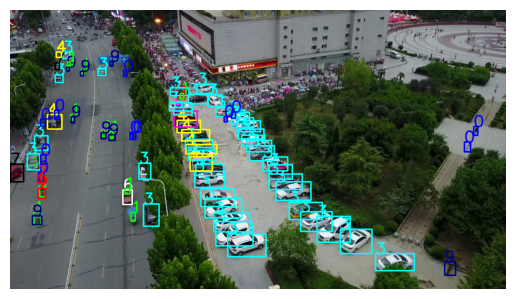

In [26]:
# 训练集中选择图片及对应标注
test_file = train_dir + '/images/0000002_00005_d_0000014.jpg'
label_file =  train_dir + '/labels/0000002_00005_d_0000014.txt'
yoloDraw(test_file, label_file)

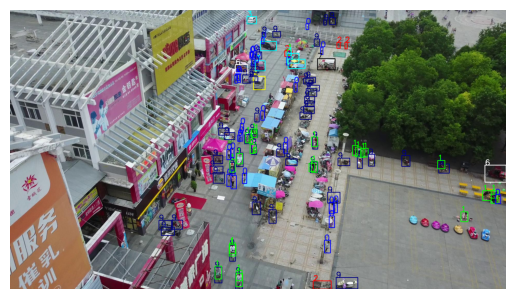

In [27]:
# 测试集中选择图片及对应标注
test_file = val_dir + '/images/0000001_04527_d_0000008.jpg'
label_file = val_dir + '/labels/0000001_04527_d_0000008.txt'
yoloDraw(test_file, label_file)